In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import csv
import matplotlib.pyplot as plt 
import collections
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from tqdm import tqdm
 

from collections import Counter
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

### Gridsearch
from pprint import pprint
from time import time
import logging
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /home/l/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/l/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Importieren der aller Classifier von SKLearn

In [2]:
from sklearn.utils import all_estimators

estimators = all_estimators(type_filter='classifier')

all_clfs = []
for name, ClassifierClass in estimators:
    try:
        clf = ClassifierClass()
        all_clfs.append(clf)
    except Exception as e:
        print('Unable to import', name)
        print(e)
        
names =[]
classifiers = all_clfs

for classifier in all_clfs: 
    
    string = str(classifier).strip("()")
    names.append(string)

Unable to import ClassifierChain
__init__() missing 1 required positional argument: 'base_estimator'
Unable to import MultiOutputClassifier
__init__() missing 1 required positional argument: 'estimator'
Unable to import OneVsOneClassifier
__init__() missing 1 required positional argument: 'estimator'
Unable to import OneVsRestClassifier
__init__() missing 1 required positional argument: 'estimator'
Unable to import OutputCodeClassifier
__init__() missing 1 required positional argument: 'estimator'
Unable to import StackingClassifier
__init__() missing 1 required positional argument: 'estimators'
Unable to import VotingClassifier
__init__() missing 1 required positional argument: 'estimators'


### Laden der Trainings und Testdaten

In [3]:
#Laden der Daten

train = pd.read_csv("train_data_w_ingredients.csv", sep=';', error_bad_lines=False, index_col=0)
test_final = pd.read_csv("test_data_w_ingredients.csv", sep=';', error_bad_lines=False, index_col=0)

#train.head(3)
#test_final.head(3)

Löschen der unnötigen Spalten

In [4]:
train.drop(["index"], axis=1, inplace=True)
train.drop(["name"], axis=1, inplace=True)
test_final.drop(["index"], axis=1, inplace=True)
test_final.drop(["name"], axis=1, inplace=True)

In [5]:
print("----------------------")
print("Document Count")
print(train.groupby('cuisine').count())
print()
print("----------------------")
print("Test Count")
print(test_final.groupby('cuisine').count())

----------------------
Document Count
            ingredients
cuisine                
Chinese              60
Greek                50
Iberic               40
Italian              50
Thai                 50
Vietnamese           50
french               50
korean               50

----------------------
Test Count
            ingredients
cuisine                
Chinese               5
Greek                 5
Iberic                5
Italian               5
Thai                  5
Vietnamese            5
french                5
korean                5


#### Preprocessing
Es werden alle unnötigen Symbole, Zahlen und Stopwörter entfernt.
Anschließend nutzen wir den PorterStemmer und Lemmatisieren wir die tokens.

In [6]:
def preprocess(text):
    text=str(text) #stringify
    text = text.lower() #kleinschreibung
    text = re.sub("\(.*?\)","()",text) #Alternativen entfernen - also alles zwischen ( )
    text=text.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words] 
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    return " ".join(lemma_words)

In [7]:
# Apply to the DF series
train['cleanText']=train['ingredients'].map(lambda s:preprocess(s)) 
train.drop(["ingredients"], axis=1, inplace=True)
test_final['cleanText']=test_final['ingredients'].map(lambda s:preprocess(s)) 
test_final.drop(["ingredients"], axis=1, inplace=True)

In [8]:
train["cleanText"].sample(8)

258    tablespoon oil onion clove garlic ounc ground ...
335    skinless chicken breast salt pepper cup cornst...
23     spring roll shrimp cucumb small carrot ounc bu...
294    cup thai basil leav tablespoon dri roast peanu...
331    tablespoon hot water teaspoon honey teaspoon s...
272    rice paper wrap red pepper cup romain cup cook...
90     tablespoon oliv oil onion garlic clove pound g...
213    tablespoon oil tablespoon butter pound prawn l...
Name: cleanText, dtype: object

# Baseline Test

In [9]:
test = train
ok_classifiers = []
ok_names = []
X = test['cleanText']
Y = test['cuisine']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=8)

count = -1

baseline_test = []

for name, clf in tqdm(zip(names, classifiers)):
    
    count = count + 1
    
    try:
        pipeline = Pipeline([('vect', CountVectorizer()),
                                 ('clf', clf),
                                ])

        pipeline.fit(x_train, y_train)

        y_pred = pipeline.predict(x_test)
        score = accuracy_score(y_pred, y_test)

        dict1 = {
                    "Classifier": name,
                    "Accuracy": score,

                }
        baseline_test.append(dict1)
        
        ok_classifiers.append(clf)
        ok_names.append(name)
        
        #print(count)
        #print("------------------")
        #print(name)
        #print(score)
        #print("------------------")
        #print()
        
    except:
        print("Delete")
        print(name)

    
 
    
    

result_baseline = pd.DataFrame(baseline_test)

print(len(ok_names))
print(len(ok_classifiers))
print(len(baseline_test))

result_baseline

10it [00:00, 21.99it/s]

Delete
CategoricalNB
Delete
GaussianNB
Delete
GaussianProcessClassifier


20it [00:01, 12.63it/s]

Delete
HistGradientBoostingClassifier
Delete
LabelPropagation
Delete
LabelSpreading
Delete
LinearDiscriminantAnalysis


30it [00:05,  5.48it/s]

Delete
QuadraticDiscriminantAnalysis
Delete
RadiusNeighborsClassifier


34it [00:05,  6.34it/s]

25
25
25


,Classifier,Accuracy
0,AdaBoostClassifier,0.4375
1,BaggingClassifier,0.6875
2,BernoulliNB,0.8125
3,CalibratedClassifierCV,0.8125
4,ComplementNB,0.7875
5,DecisionTreeClassifier,0.4625
6,DummyClassifier,0.1250
7,ExtraTreeClassifier,0.6000
8,ExtraTreesClassifier,0.8875
9,GradientBoostingClassifier,0.7750


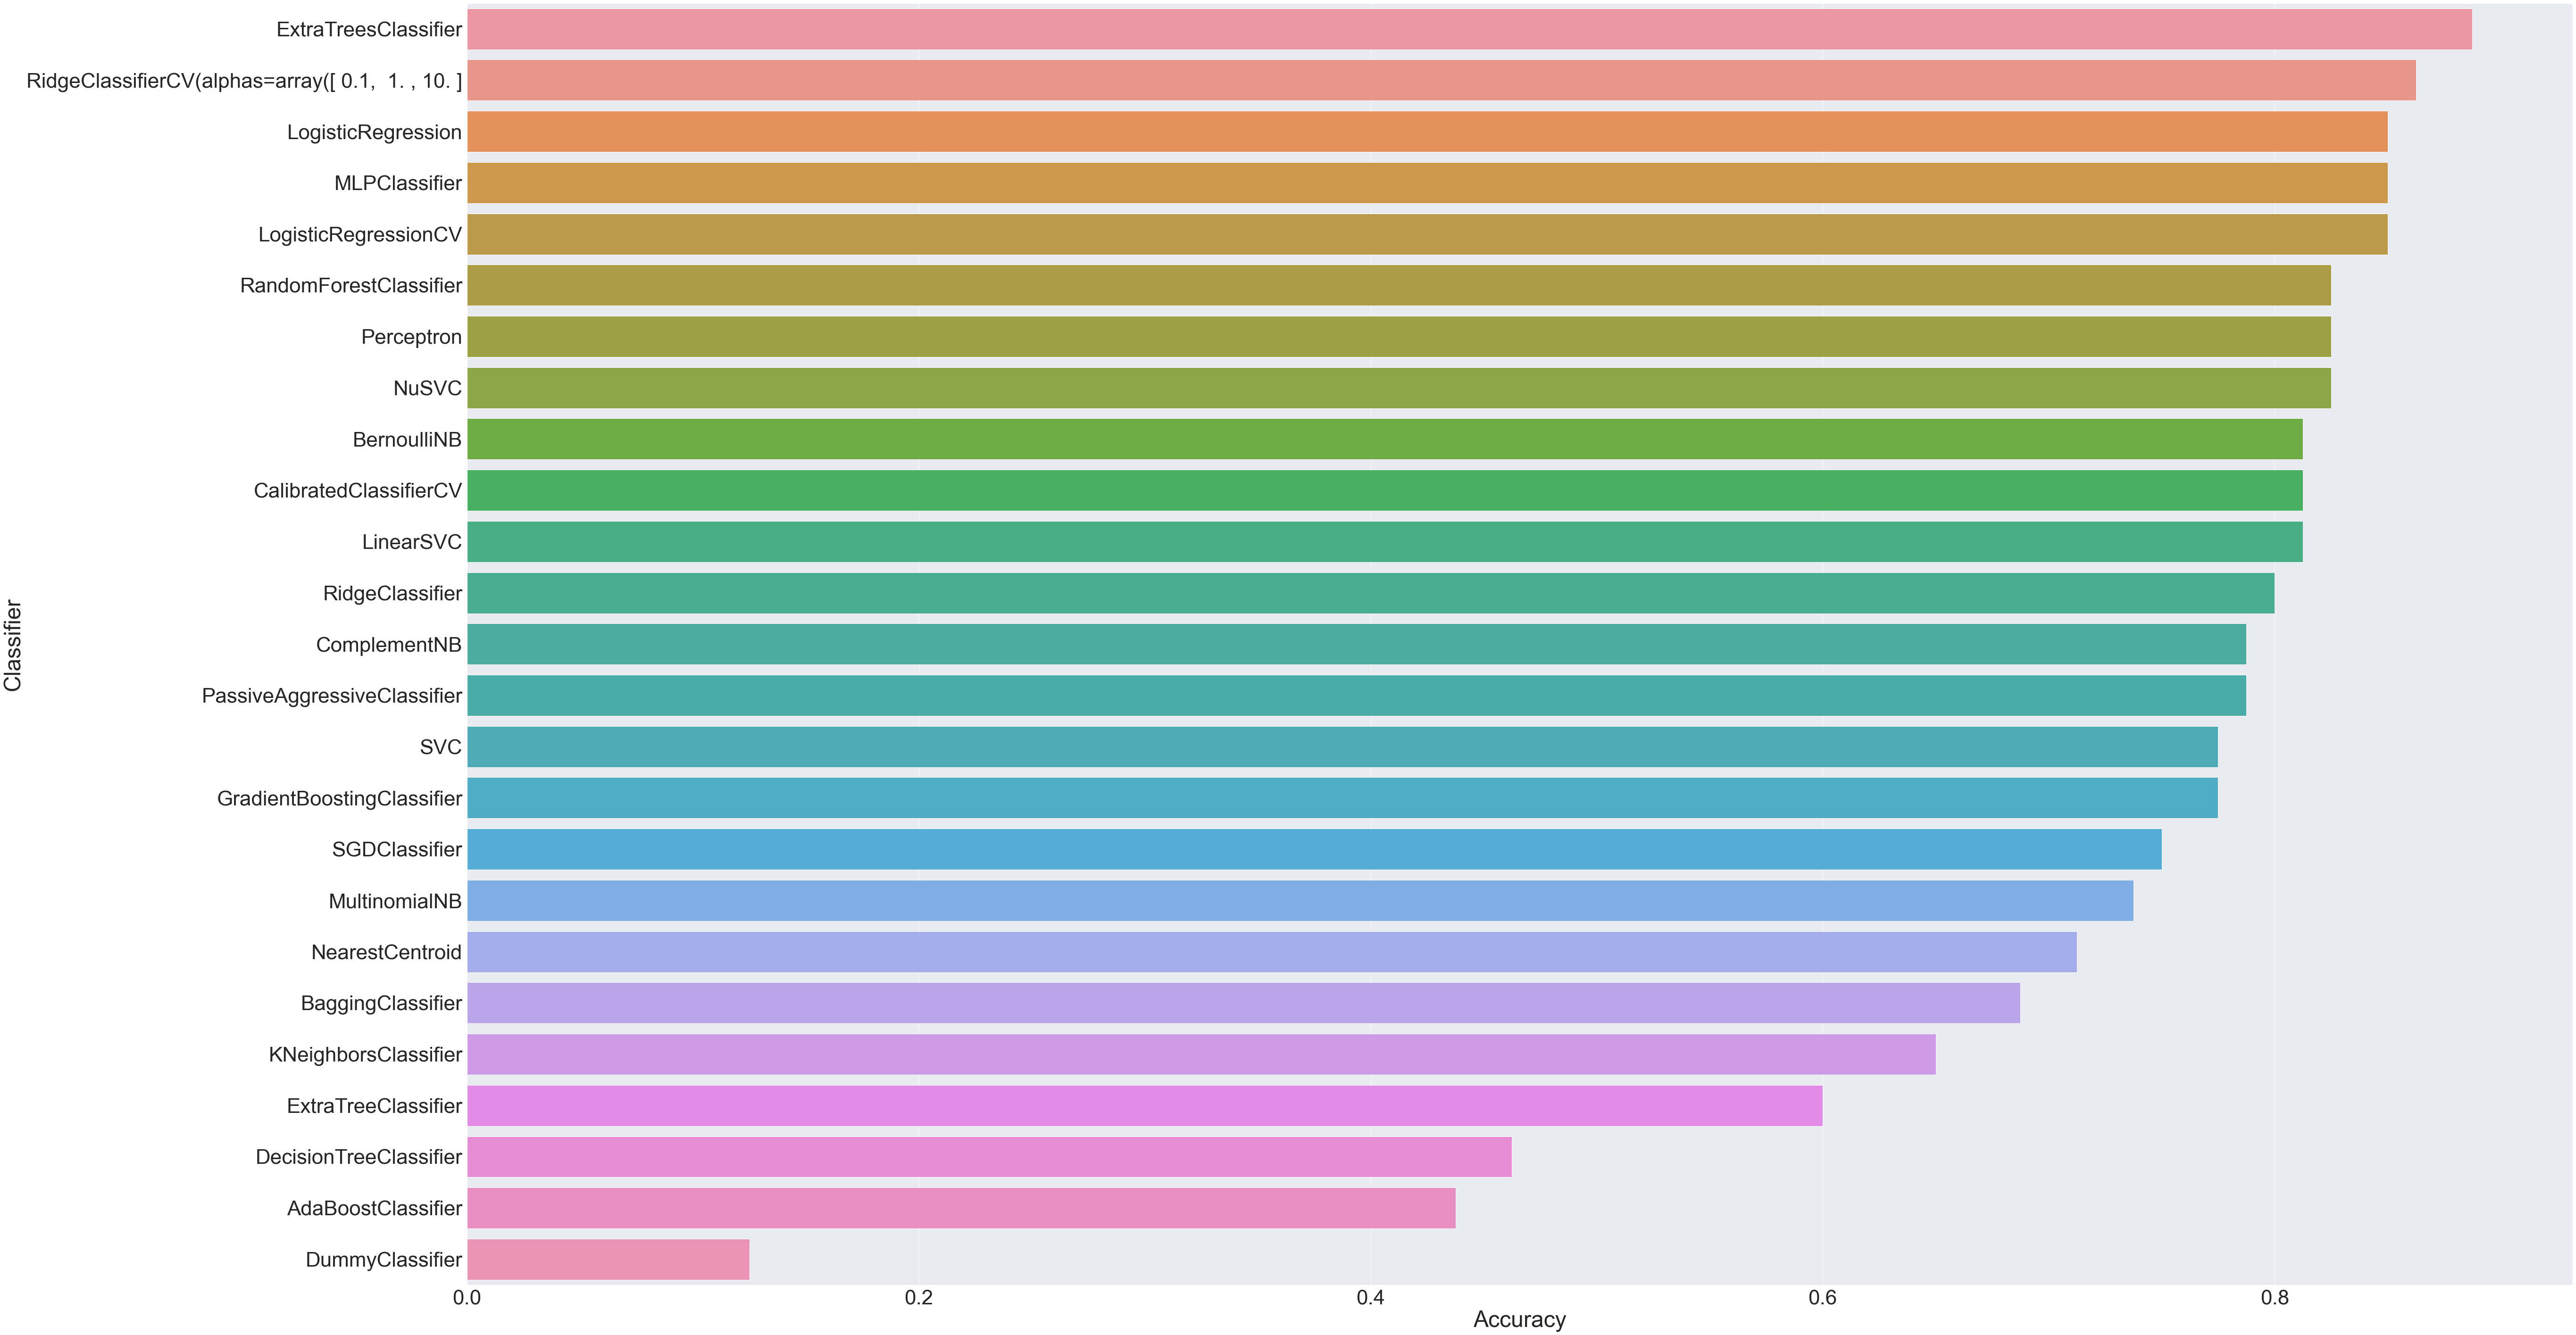

In [10]:
sorted_result_baseline = result_baseline.sort_values(by=['Accuracy'], ascending=False)

sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
plt.legend([],[], frameon=False)
sns_t = sns.barplot(
    data=sorted_result_baseline, 
    x="Accuracy", y="Classifier", hue="Classifier",dodge=False
)

plt.legend([],[], frameon=False)

# Preprocessing planing

Die Vorgab war das wir verschiedene Preprocessing Schritte durchführen. Damit wir diese Vorgabe erfüllen wir, indem wir basierend auf Variablen verschiedene Wörter aus den Rezepten entfernen. Die Preprocessing Schritte die zuvor durchgeführt wurden, setzen wir pauschal an.

#### Unsere Idee ist folgende:

Wir zählen das Vorkommen jedes einzelnen Begriffs in...

... allen Rezepten
... aufgeteilt auf die Kontinenten
... aufgeteilt für jede Küchenart

Anschließend kann man Variablen definieren die angeben wie oft minimal ein Wort vorkommen darf. Dadurch erhalten wir einen Dataframe indem alle Begriff sind die Häufiger als die vorgabe erscheinen und damit weniger zu Unterscheidung der Küchen dienen. Die Begriff die also noch indem Wörter Dataframe vorhanden sind, ergeben anschließend unsere Remove-Liste. In ihr sind dann die Begriffe die in allen Rezepten entfernt werden.


#### Hinzufügen der Spalte Continental

Anhand der europäischen Küchen wird entschieden, ob eine Küche auf dem europäischen Kontinent oder auf dem asiatischen Kontinent beheimatet ist.

In [11]:
european = ["Italian","Iberic","french","Greek"]

def continental (row):
    if row['cuisine'] in european:
        return 'european'
    return 'asian'

train["continental"]=train.apply(lambda row: continental(row), axis=1)
train.sample(15)

,cuisine,cleanText,continental
171,korean,tablespoon brown sugar tablespoon reduc sodium...,asian
321,Chinese,chicken thigh tablespoon oliv oil teaspoon min...,asian
124,french,cup water cup whole milk tablespoon unsalt but...,european
189,korean,batch sauc pound flank steak bell pepper red o...,asian
377,Iberic,pound sea scallop teaspoon salt teaspoon black...,european
389,Iberic,tablespoon extra virgin oliv oil medium onion ...,european
106,french,prime rib roast salt black pepper tablespoon h...,european
91,Greek,cup brown lentil cup veget stock onion cup cho...,european
288,Thai,pound ground chicken clove minc garlic teaspoo...,asian
168,korean,packag imposs burger clove garlic pear tablesp...,asian


## Unser Weg zu unserer Preprocessing Funktion

Zählen des Vorkommens der verschiedenen Wörter in allen Küchen.

In [12]:
d = Counter(" ".join(train["cleanText"]).split()).most_common()

all_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient','overall_count'])
all_recipes_df.head(10)

,ingredient,overall_count
0,tablespoon,1059
1,cup,985
2,teaspoon,855
3,oil,361
4,sauc,327
5,pepper,327
6,garlic,309
7,salt,297
8,onion,250
9,pound,248


Zählen des Vorkommens der verschiedenen Wörter auf dem asiatischen Kontinent.

In [13]:
asian_recipes_df = train.loc[train['continental'] == 'asian']

d = Counter(" ".join(asian_recipes_df["cleanText"]).split()).most_common()

asian_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['asian_ingredient','asian_count'])
asian_recipes_df

,asian_ingredient,asian_count
0,tablespoon,715
1,cup,480
2,teaspoon,440
3,sauc,302
4,oil,210
...,...,...
401,lite,1
402,chestnut,1
403,almond,1
404,xanthan,1


Jetzt wissen wir wie simple es möglich ist eine Tabelle zu erstellen in der jedes Wort für jeden Kontinent, sowie Küche, gezählt werden kann.

##### Überprüfung der Annahme

Wir erstellen zu Testzwecken zwei For-Schleifen um zu schauen wie der Dataframe aussieht.

In [14]:
# Liste mit allen Küchenarten erstellen

cuisine_names = list(train['cuisine'].value_counts().index)
cuisine_names

['Chinese',
 'korean',
 'french',
 'Greek',
 'Thai',
 'Italian',
 'Vietnamese',
 'Iberic']

In [15]:
# Liste mit allen Kontinenten erstellen

continental_names = list(train['continental'].value_counts().index)
continental_names

['asian', 'european']

In [16]:
test = all_recipes_df

for cuisine in continental_names:
    df = train.loc[train['continental'] == cuisine] #reduzieren auf den aktuellen Kontinent
    
    d = Counter(" ".join(df["cleanText"]).split()).most_common() #zählen der Wörter

    count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine]) # in seperaten Dataframe speichern
    test = pd.merge(test, count_df, on='ingredient', how='left') # verbinden der beiden Dataframes ohne Elemente zu löschen (basis = test)
    
    
for cuisine in cuisine_names:
    df = train.loc[train['cuisine'] == cuisine] #reduzieren auf die aktuelle Küchenart
    
    d = Counter(" ".join(df["cleanText"]).split()).most_common() #zählen der Wörter

    count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
    test = pd.merge(test, count_df, on='ingredient', how='left') # verbinden der beiden Dataframes ohne Elemente zu löschen (basis = test)
    

test

,ingredient,overall_count,asian,european,Chinese,korean,french,Greek,Thai,Italian,Vietnamese,Iberic
0,tablespoon,1059,715.0,344.0,191.0,191.0,126.0,96.0,199.0,76.0,134.0,46.0
1,cup,985,480.0,505.0,145.0,110.0,144.0,139.0,115.0,151.0,110.0,71.0
2,teaspoon,855,440.0,415.0,154.0,124.0,106.0,161.0,94.0,85.0,68.0,63.0
3,oil,361,210.0,151.0,76.0,69.0,34.0,50.0,38.0,32.0,27.0,35.0
4,sauc,327,302.0,25.0,89.0,55.0,2.0,2.0,80.0,17.0,78.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
647,poppi,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
648,sweeten,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
649,condens,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
650,full,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


Man sieht das nachdem einfachen Preprocessing noch 652 Wörter übrig geblieben sind, die aber sehr unterschiedlich oft in den verschiedenen Küchen sowie Kontinenten verwendet werden.

##### Erster Versuch eine Liste zu erstellen die durch einen minimal Wert erstellt wird

Anhand des Test-minimal-Wertes von 2 prüfen wir, ob in dem Dataframe alle Wörter bleiben deren Anzahl in den Spalten asian und european größer ist.

In [17]:
indexList = []

remove_test = test

for cuisine in continental_names:
    indexNames = remove_test[ remove_test[cuisine] <= 2 ].index
    for i in indexNames:        
        if i in indexList:
            pass
        else:
            indexList.append(i)
            
            

remove_test.drop(indexList , inplace=True)
remove_list = remove_test['ingredient'].tolist()

print("Length of remove_list")
print(len(remove_list))

Length of remove_list
252


In [18]:
remove_test

,ingredient,overall_count,asian,european,Chinese,korean,french,Greek,Thai,Italian,Vietnamese,Iberic
0,tablespoon,1059,715.0,344.0,191.0,191.0,126.0,96.0,199.0,76.0,134.0,46.0
1,cup,985,480.0,505.0,145.0,110.0,144.0,139.0,115.0,151.0,110.0,71.0
2,teaspoon,855,440.0,415.0,154.0,124.0,106.0,161.0,94.0,85.0,68.0,63.0
3,oil,361,210.0,151.0,76.0,69.0,34.0,50.0,38.0,32.0,27.0,35.0
4,sauc,327,302.0,25.0,89.0,55.0,2.0,2.0,80.0,17.0,78.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
331,cauliflow,3,3.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN
332,belli,3,3.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
335,kidney,3,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0
336,cashew,3,3.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN


Man sieht das alle Begriff die noch indem Dataframe sind eine mindest Anzahl von 3 aufweisen. Aber die NaN Werte wurden nicht herausgefiltert.

In [19]:
#zweiter versuch

indexList = []

remove_test = test
remove_test.fillna(0, inplace=True)

for cuisine in continental_names:
    indexNames = remove_test[ remove_test[cuisine] <= 2 ].index
    for i in indexNames:        
        if i in indexList:
            pass
        else:
            indexList.append(i)
            
            

remove_test.drop(indexList , inplace=True)
remove_list = remove_test['ingredient'].tolist()

print("Length of remove_list")
print(len(remove_list))

Length of remove_list
130


In [20]:
remove_test

,ingredient,overall_count,asian,european,Chinese,korean,french,Greek,Thai,Italian,Vietnamese,Iberic
0,tablespoon,1059,715.0,344.0,191.0,191.0,126.0,96.0,199.0,76.0,134.0,46.0
1,cup,985,480.0,505.0,145.0,110.0,144.0,139.0,115.0,151.0,110.0,71.0
2,teaspoon,855,440.0,415.0,154.0,124.0,106.0,161.0,94.0,85.0,68.0,63.0
3,oil,361,210.0,151.0,76.0,69.0,34.0,50.0,38.0,32.0,27.0,35.0
4,sauc,327,302.0,25.0,89.0,55.0,2.0,2.0,80.0,17.0,78.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
198,appl,8,4.0,4.0,2.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0
201,turkey,8,4.0,4.0,1.0,1.0,0.0,4.0,2.0,0.0,0.0,0.0
202,sherri,8,5.0,3.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
223,warm,6,3.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0


Die Anzahl der Wörter wurde nochmal deutlich reduziert, weil jetzt natürlich alle NaN werte durch 0 ersetzt wurden.

Selbes Schema aber nun die Küchenarten. Die Vermutung ist natürlich das die Liste nun deutlich kleiner wird.

In [21]:
#dritter versuch

indexList = []

remove_test = test
remove_test.fillna(0, inplace=True)

for cuisine in cuisine_names:
    indexNames = remove_test[ remove_test[cuisine] <= 2 ].index
    for i in indexNames:        
        if i in indexList:
            pass
        else:
            indexList.append(i)
            
            

remove_test.drop(indexList , inplace=True)
remove_list = remove_test['ingredient'].tolist()

print("Length of remove_list")
print(len(remove_list))

Length of remove_list
25


Wir haben jetzt also eine Remove_List mit der wir anschließend jeden der Classifier prüfen können. Nun wird alles in eine Funktion gepackt.

## Eigene Funktion die automatisch eine Liste erzeugt

Die Funktion generiert anhand von verschiedenen minimal_werten eine Liste von Wörtern.

In [22]:
def generate_remove_list(df, min_overall_count, min_count_in_cuisine):
    
    indexList = []
    
    cuisine_names = list(df['cuisine'].value_counts().index)
    continental_names = list(df['continental'].value_counts().index)
    
    d = Counter(" ".join(df["cleanText"]).split()).most_common()
    all_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient','overall_count'])
    words_df = all_recipes_df
    
    for cuisine in continental_names:
        df = train.loc[train['continental'] == cuisine]

        d = Counter(" ".join(df["cleanText"]).split()).most_common()

        count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
        words_df = pd.merge(words_df, count_df, on='ingredient', how='left')
    
    
    for cuisine in cuisine_names:
        df = train.loc[train['cuisine'] == cuisine]

        d = Counter(" ".join(df["cleanText"]).split()).most_common()

        count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
        words_df = pd.merge(words_df, count_df, on='ingredient', how='left')
        
    words_df.fillna(0, inplace=True)
    for cuisine in continental_names:
        indexNames = []
        indexNames = words_df[ words_df[cuisine] <= min_overall_count ].index
        
        for i in indexNames:        
            if i in indexList:
                pass
            else:
                indexList.append(i)
    
    for cuisine in cuisine_names:
        indexNames = []
        indexNames = words_df[ words_df[cuisine] <= min_count_in_cuisine ].index

        for i in indexNames:        
            if i in indexList:
                pass
            else:
                indexList.append(i)




    words_df.drop(indexList , inplace=True)
    
    remove_list = words_df['ingredient'].tolist()
    

    
    
    return remove_list

In [23]:
#Test der Funktion

remove_list = generate_remove_list(train, 1 , 1)
print(len(remove_list))
print(remove_list)

36
['tablespoon', 'cup', 'teaspoon', 'oil', 'sauc', 'pepper', 'garlic', 'salt', 'onion', 'pound', 'clove', 'fresh', 'ounc', 'red', 'sugar', 'chicken', 'oliv', 'ground', 'black', 'egg', 'water', 'butter', 'vinegar', 'juic', 'wine', 'white', 'chop', 'veget', 'boneless', 'freshli', 'powder', 'broth', 'larg', 'pinch', 'flake', 'yellow']


In [24]:
# Funktion, um Wörter die in einer Liste sind aus den Zutaten zu löschen

def remove_common_words(sentence, rem_list):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in rem_list]
    return " ".join(filtered_words)

In [25]:
# Zum vergleichen
test_if_removed = train
test_if_removed

,cuisine,cleanText,continental
1,Vietnamese,cup beef broth cup water yellow onion clove ga...,asian
2,Vietnamese,pound ground chicken tablespoon fish sauc onio...,asian
3,Vietnamese,pound pork blade steak tablespoon light brown ...,asian
4,Vietnamese,pound chicken thigh tablespoon oil clove garli...,asian
5,Vietnamese,marrow bone ounc beef stock ounc water onion g...,asian
...,...,...,...
396,Iberic,tablespoon oliv oil chicken thigh gram chorizo...,european
397,Iberic,tablespoon oliv oil chicken thigh gram chorizo...,european
398,Iberic,teaspoon oliv oil cup rice red bell pepper oni...,european
399,Iberic,pound boneless chicken thigh teaspoon smoke pa...,european


In [26]:
# Wörter werden gelöscht aus den Rezepten
test_if_removed['cleanText_removed']=test_if_removed['cleanText'].map(lambda s:remove_common_words(s, remove_list)) 
test_if_removed.head(3)

,cuisine,cleanText,continental,cleanText_removed
1,Vietnamese,cup beef broth cup water yellow onion clove ga...,asian,beef whole star ani whole ginger cinnamon stic...
2,Vietnamese,pound ground chicken tablespoon fish sauc onio...,asian,fish stalk lemongrass cilantro mint cornstarch...
3,Vietnamese,pound pork blade steak tablespoon light brown ...,asian,pork blade steak light brown shallot stalk lem...


In der ersten Zeile sieht man, dass das Wort "Cup" entfernt wurde. Es funktioniert also!

### Funktion, um alle Classifier mit verschiedenen Remove_Lists zu testen

In [27]:
rows_list = []

def test_classifier_with_remove(clf,name, array):
    for i in tqdm(array):
        for e in tqdm(array):
            test = train

            remove_list = generate_remove_list(test, i , e)
            len_remove_list = len(remove_list)

            test['cleanText_removed']=test['cleanText'].map(lambda s:remove_common_words(s, remove_list))

            X = test['cleanText_removed']
            Y = test['cuisine']
            x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                                test_size=.2, 
                                                                random_state=8)


            pipeline = Pipeline([('vect', CountVectorizer()),
                                 ('clf', clf),
                                ])

            pipeline.fit(x_train, y_train)

            y_pred = pipeline.predict(x_test)
            score = accuracy_score(y_pred, y_test)

            dict1 = {
                        "Length of remove_list": len_remove_list,
                        "Accuracy": score,
                        "Removed words": remove_list,
                        "Classifier": name,
                        "Method": "auto"
                    }
            rows_list.append(dict1)

In [28]:
# zu testende minimal Werte

array = [0,1,2,3,5,10,100,1000,1100]

#Aufrufen der Funktion mit jedem Classifier der beim Baseline Test funktioniert hat
for name, clf in tqdm(zip(ok_names, ok_classifiers)):

    test_classifier_with_remove(clf,name,array)
    
result = pd.DataFrame(rows_list)

0it [00:00, ?it/s]
  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:00<00:01,  6.42it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.22it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.43it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.52it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.67it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  6.61it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  6.56it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.52it/s]

100%|██████████| 9/9 [00:01<00:00,  6.53it/s]

 11%|█         | 1/9 [00:01<00:11,  1.38s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:00<00:01,  7.08it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.06it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.75it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.56it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.57it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  6.60it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  6.54it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.43it/s]

100%|██████████| 9

In [29]:
# Kleiner Blick auf das Ergebnis

result

,Length of remove_list,Accuracy,Removed words,Classifier,Method
0,50,0.4500,"[tablespoon, cup, teaspoon, oil, sauc, pepper,...",AdaBoostClassifier,auto
1,36,0.4250,"[tablespoon, cup, teaspoon, oil, sauc, pepper,...",AdaBoostClassifier,auto
2,25,0.4375,"[tablespoon, cup, teaspoon, oil, pepper, garli...",AdaBoostClassifier,auto
3,17,0.4375,"[tablespoon, cup, teaspoon, oil, pepper, garli...",AdaBoostClassifier,auto
4,15,0.4375,"[tablespoon, cup, teaspoon, oil, pepper, garli...",AdaBoostClassifier,auto
...,...,...,...,...,...
2020,0,0.7750,[],SVC,auto
2021,0,0.7750,[],SVC,auto
2022,0,0.7750,[],SVC,auto
2023,0,0.7750,[],SVC,auto


Es wurden also 2025 Kombinationen von Classifiern und remove_listen gebildet. 

<AxesSubplot:xlabel='Length of remove_list', ylabel='Accuracy'>

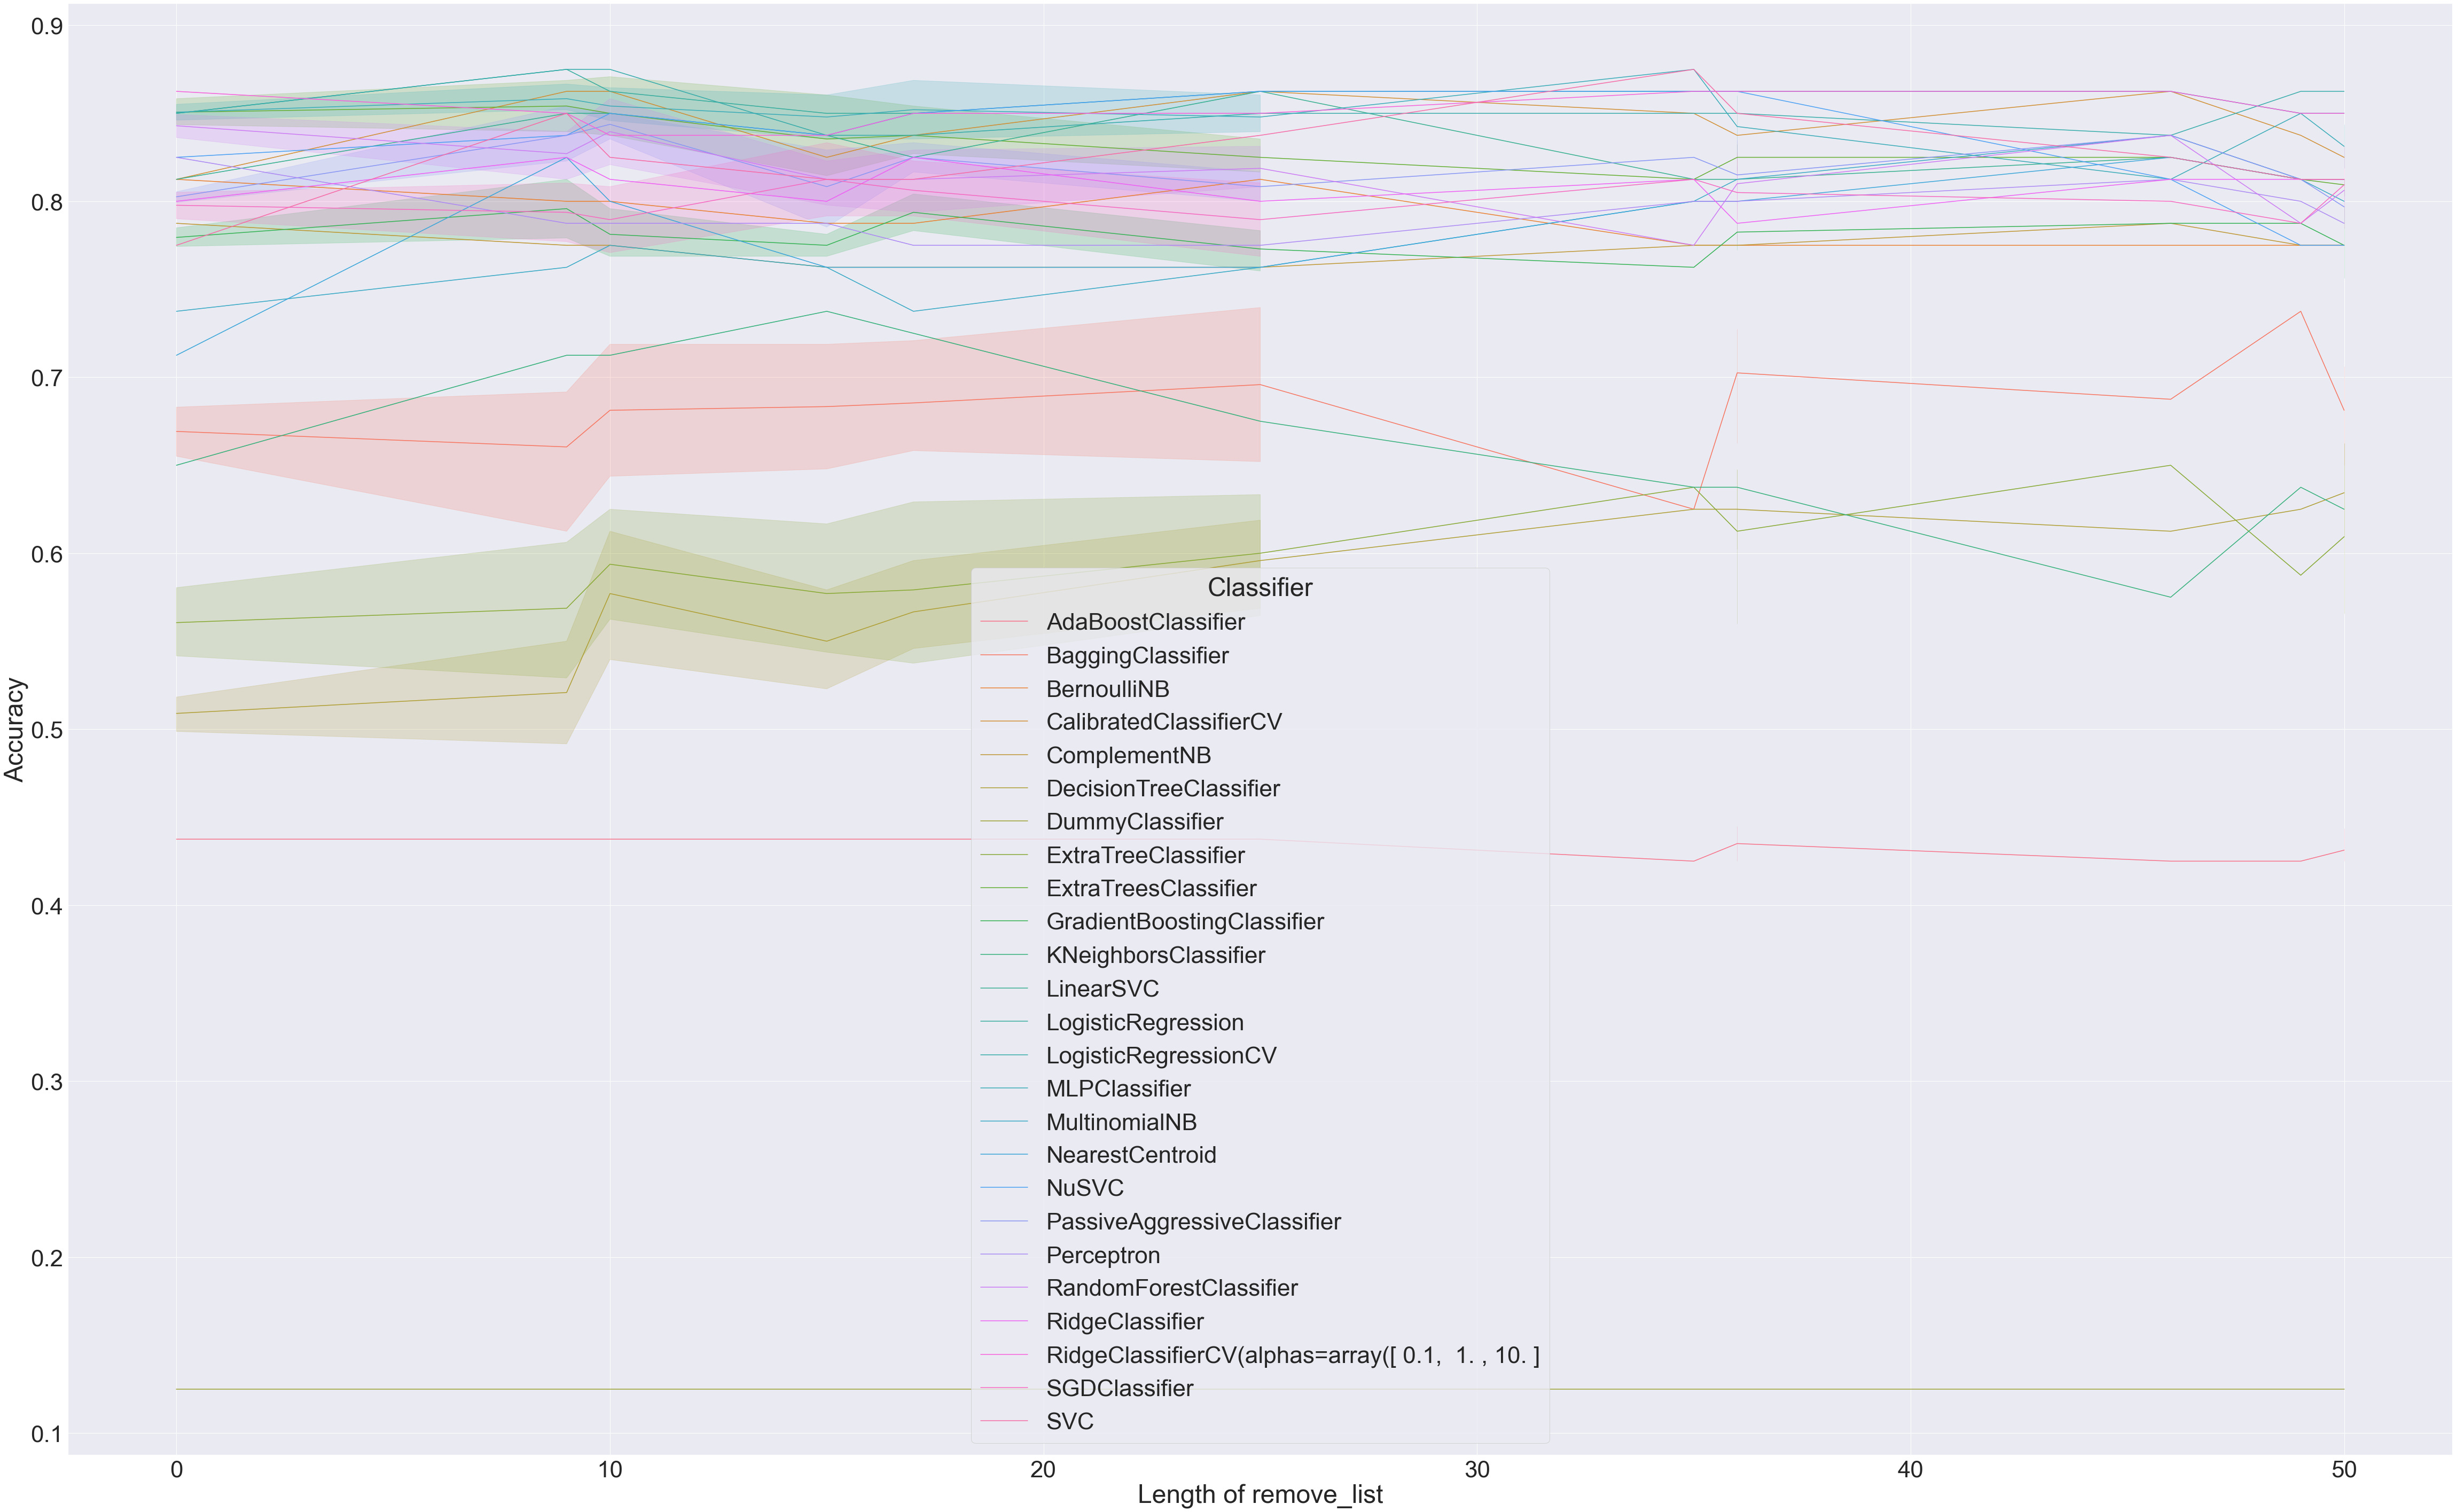

In [30]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
sns.lineplot(
    data=result, 
    x="Length of remove_list", y="Accuracy", hue="Classifier",
)

<AxesSubplot:xlabel='Accuracy', ylabel='Classifier'>

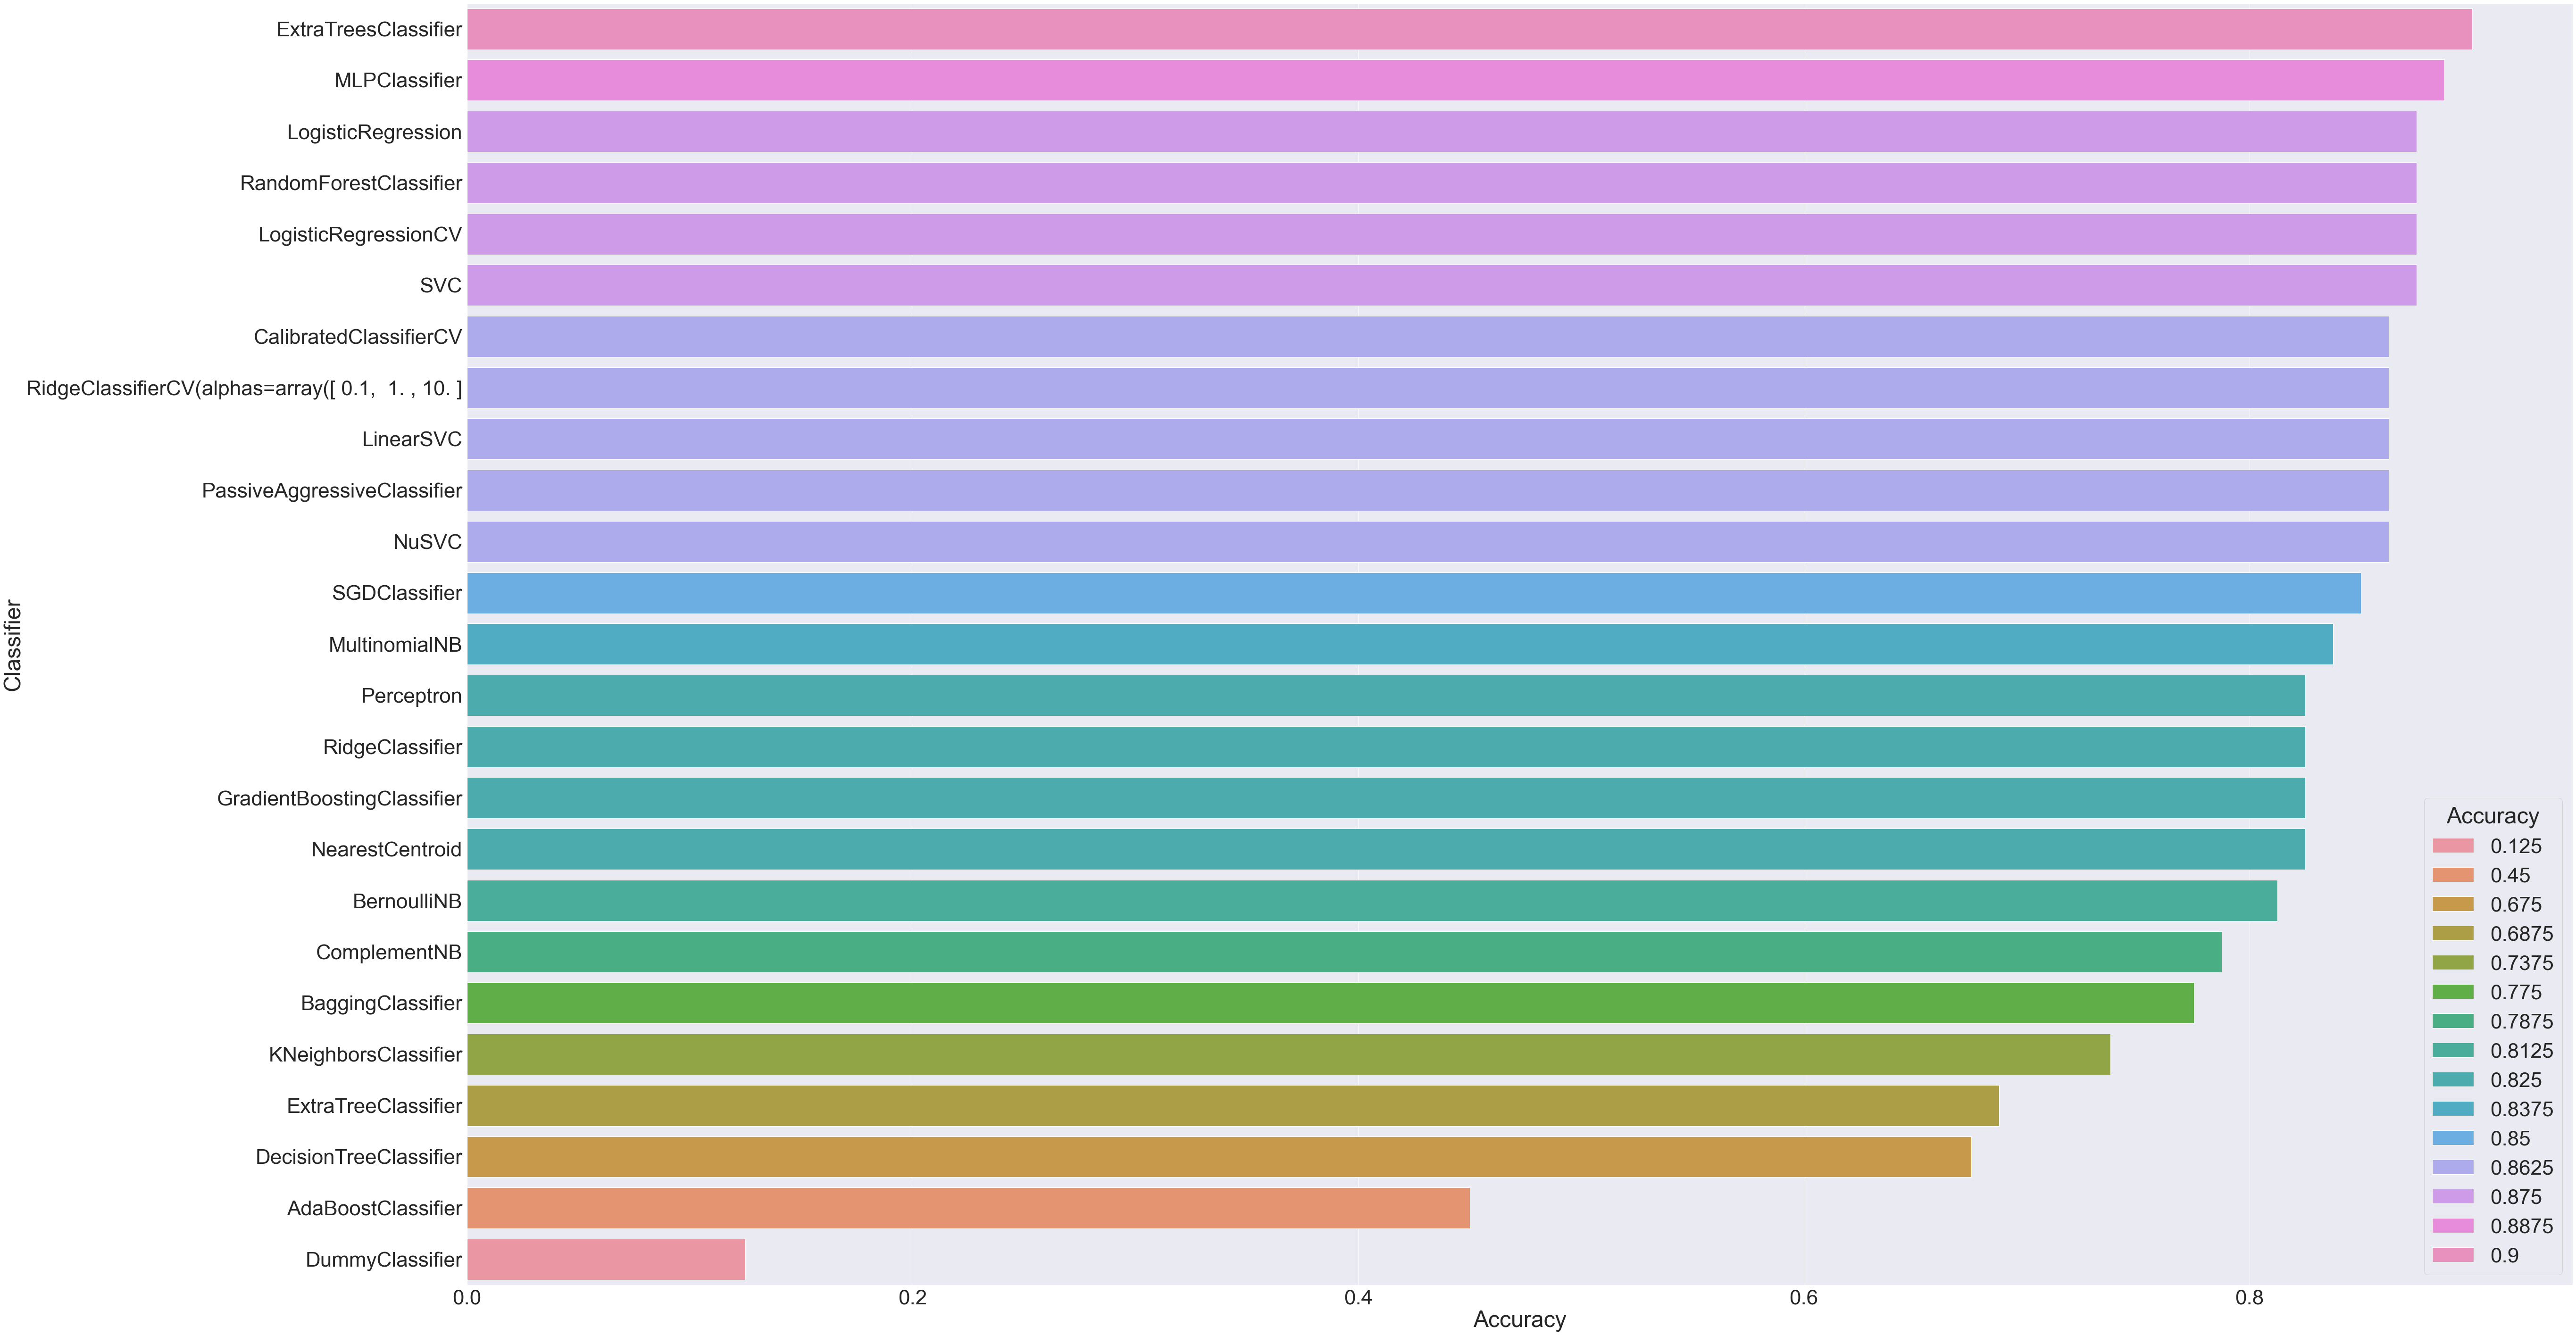

In [31]:
sorted_result = result.sort_values('Accuracy', ascending=False).drop_duplicates(['Classifier'])

sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
sns.barplot(
    data=sorted_result, 
    x="Accuracy", y="Classifier", hue="Accuracy",dodge=False
)

# TF-IDF with all Classifiers

In [32]:
tfidf_rows_list = []
X = train['cleanText']
Y = train['cuisine']
x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=.2, 
                                                    random_state=8)


# iterate over classifiers
for name, clf in zip(ok_names, ok_classifiers):

    pipeline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', clf),
              ])
    pipeline.fit(x_train, y_train)
    
    y_pred = pipeline.predict(x_test)
    score = accuracy_score(y_pred, y_test)

    dict1 = {
                "Classifier": name,
                "Accuracy": score,
                "Method": "tfidf"

            }
    tfidf_rows_list.append(dict1)
    
    
result_tfidf = pd.DataFrame(tfidf_rows_list)
result_tfidf = result_tfidf.sort_values(by=['Accuracy'], ascending=False)
result_tfidf

,Classifier,Accuracy,Method
12,LogisticRegression,0.8750,tfidf
13,LogisticRegressionCV,0.8750,tfidf
22,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]",0.8625,tfidf
3,CalibratedClassifierCV,0.8625,tfidf
21,RidgeClassifier,0.8625,tfidf
11,LinearSVC,0.8500,tfidf
18,PassiveAggressiveClassifier,0.8500,tfidf
17,NuSVC,0.8500,tfidf
14,MLPClassifier,0.8500,tfidf
24,SVC,0.8500,tfidf


<AxesSubplot:xlabel='Accuracy', ylabel='Classifier'>

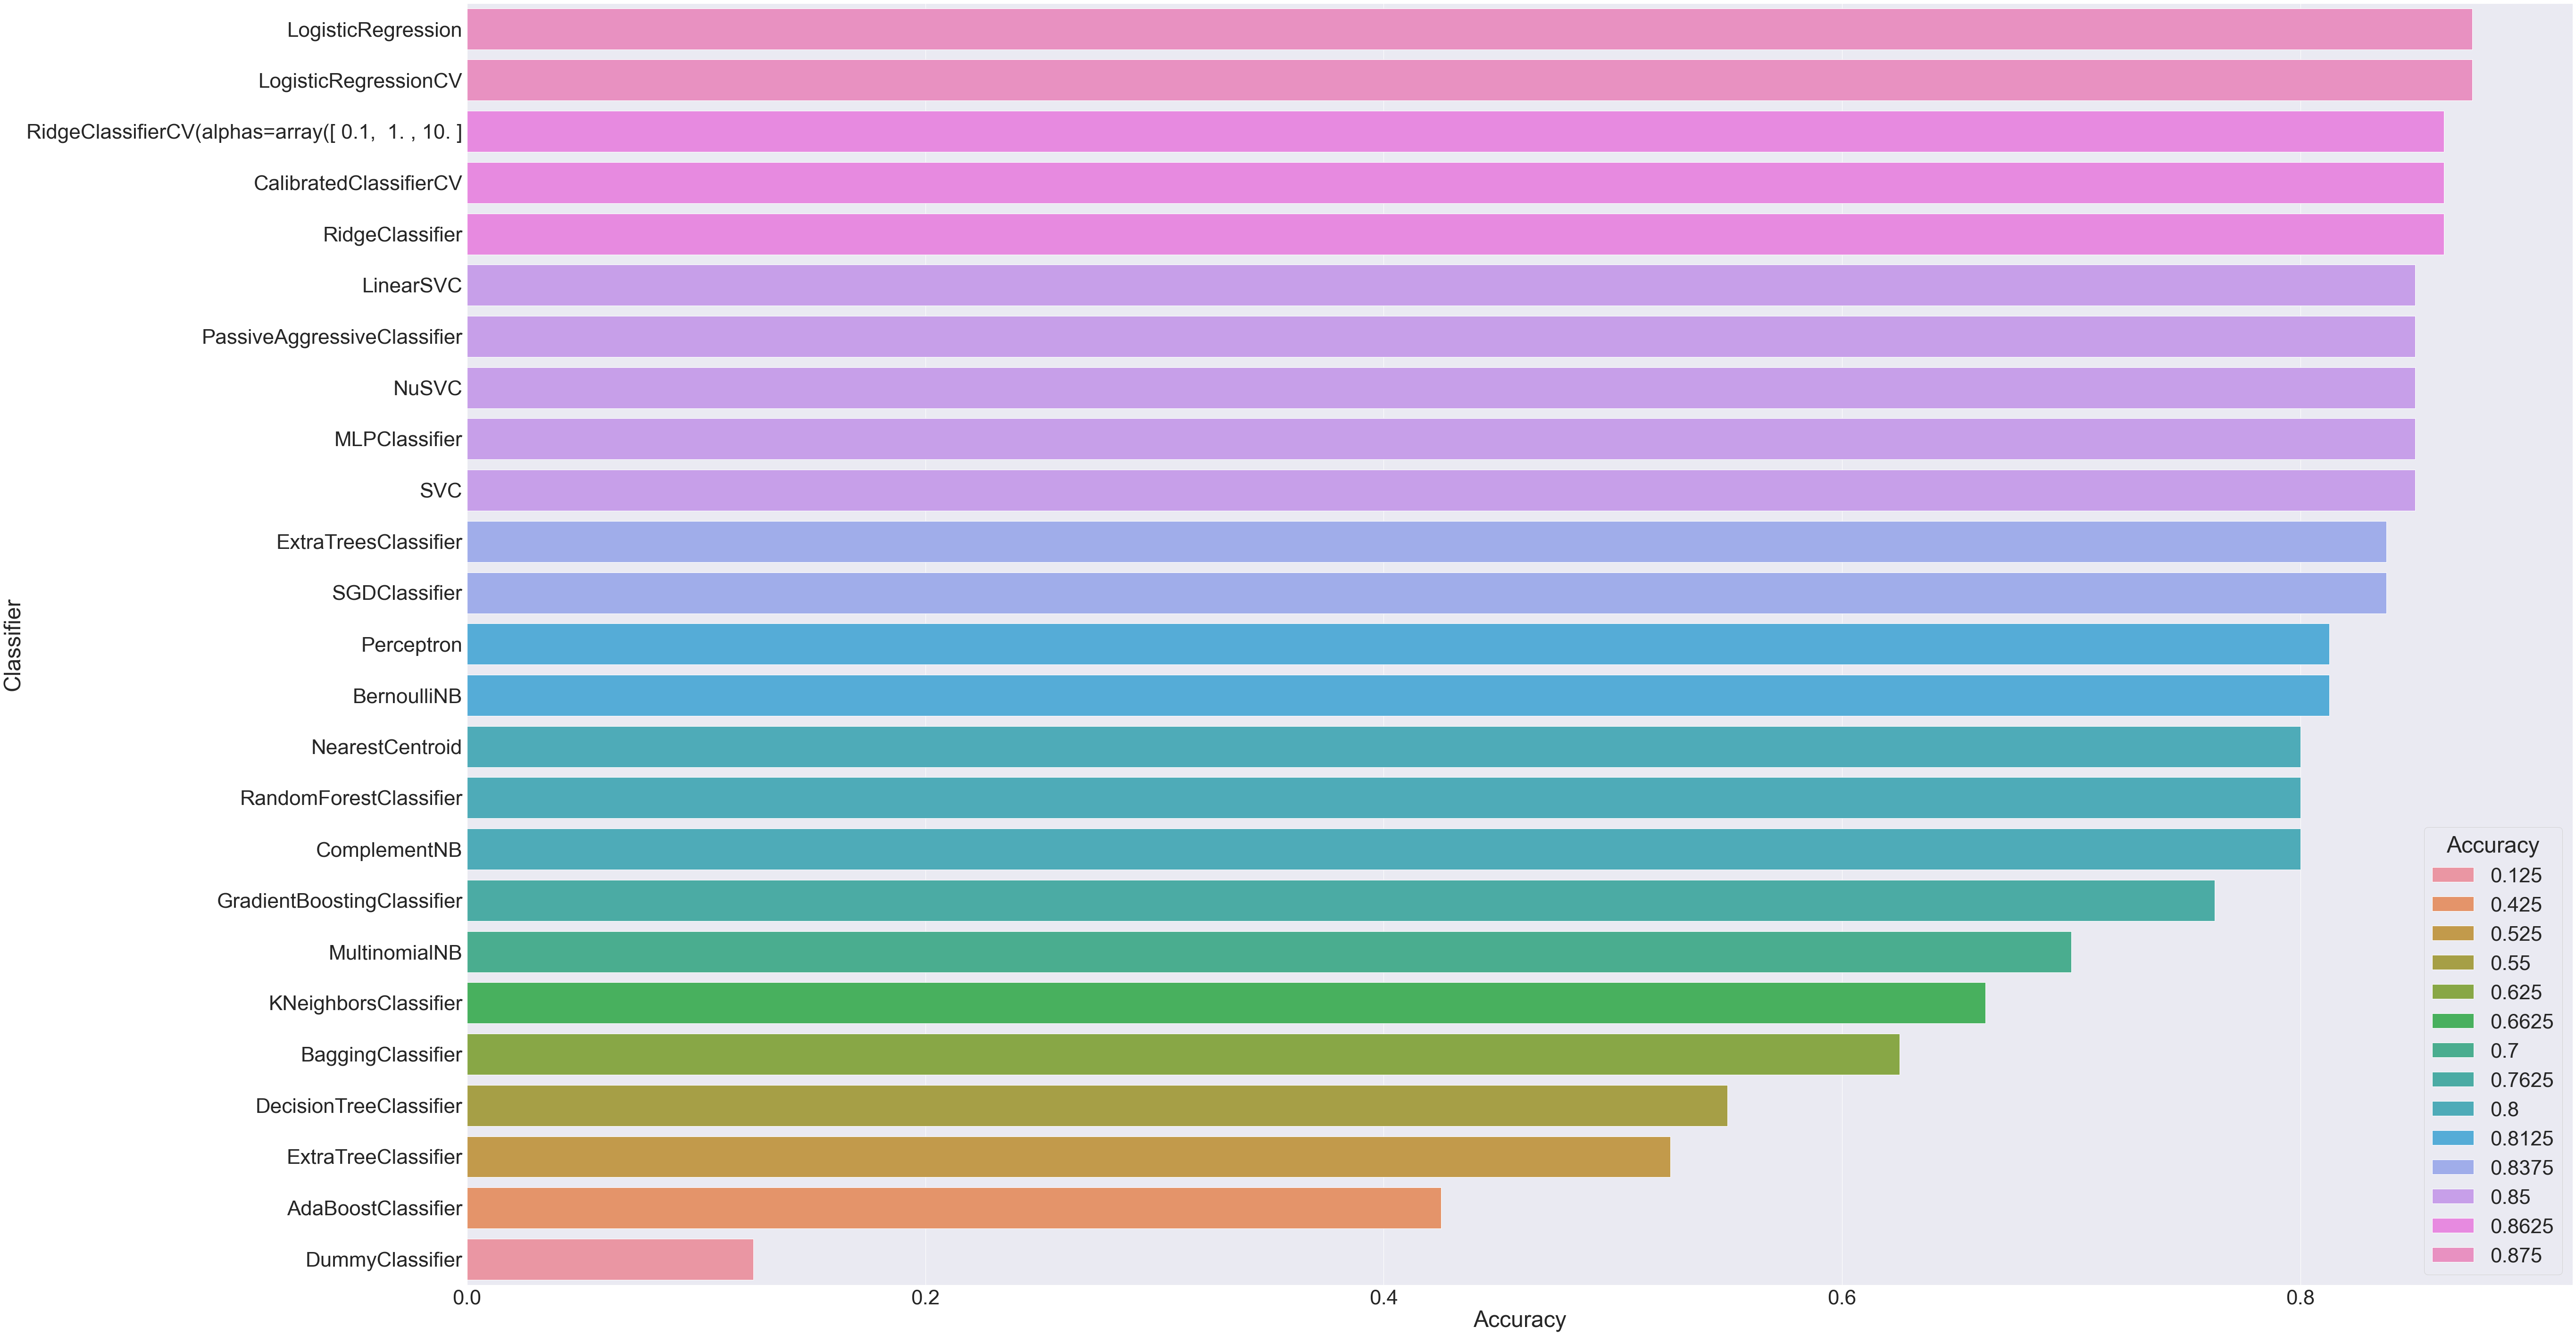

In [33]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
sns.barplot(
    data=result_tfidf, 
    x="Accuracy", y="Classifier", hue="Accuracy",dodge=False
)

In [34]:
all_classifier_combinations = sorted_result.append(result_tfidf, sort=False)

all_classifier_combinations['Method'] = all_classifier_combinations['Method'].fillna("auto")

all_classifier_combinations

,Length of remove_list,Accuracy,Removed words,Classifier,Method
713,0.0,0.9000,[],ExtraTreesClassifier,auto
1137,17.0,0.8875,"[tablespoon, cup, teaspoon, oil, pepper, garli...",MLPClassifier,auto
1027,9.0,0.8750,"[tablespoon, cup, teaspoon, oil, pepper, garli...",LogisticRegression,auto
1699,0.0,0.8750,[],RandomForestClassifier,auto
1058,10.0,0.8750,"[tablespoon, cup, teaspoon, oil, pepper, garli...",LogisticRegressionCV,auto
1990,35.0,0.8750,"[tablespoon, cup, teaspoon, oil, sauc, pepper,...",SVC,auto
254,25.0,0.8625,"[tablespoon, cup, teaspoon, oil, pepper, garli...",CalibratedClassifierCV,auto
1788,0.0,0.8625,[],"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]",auto
929,25.0,0.8625,"[tablespoon, cup, teaspoon, oil, pepper, garli...",LinearSVC,auto
1512,9.0,0.8625,"[tablespoon, cup, teaspoon, oil, pepper, garli...",PassiveAggressiveClassifier,auto


<AxesSubplot:xlabel='Accuracy', ylabel='Classifier'>

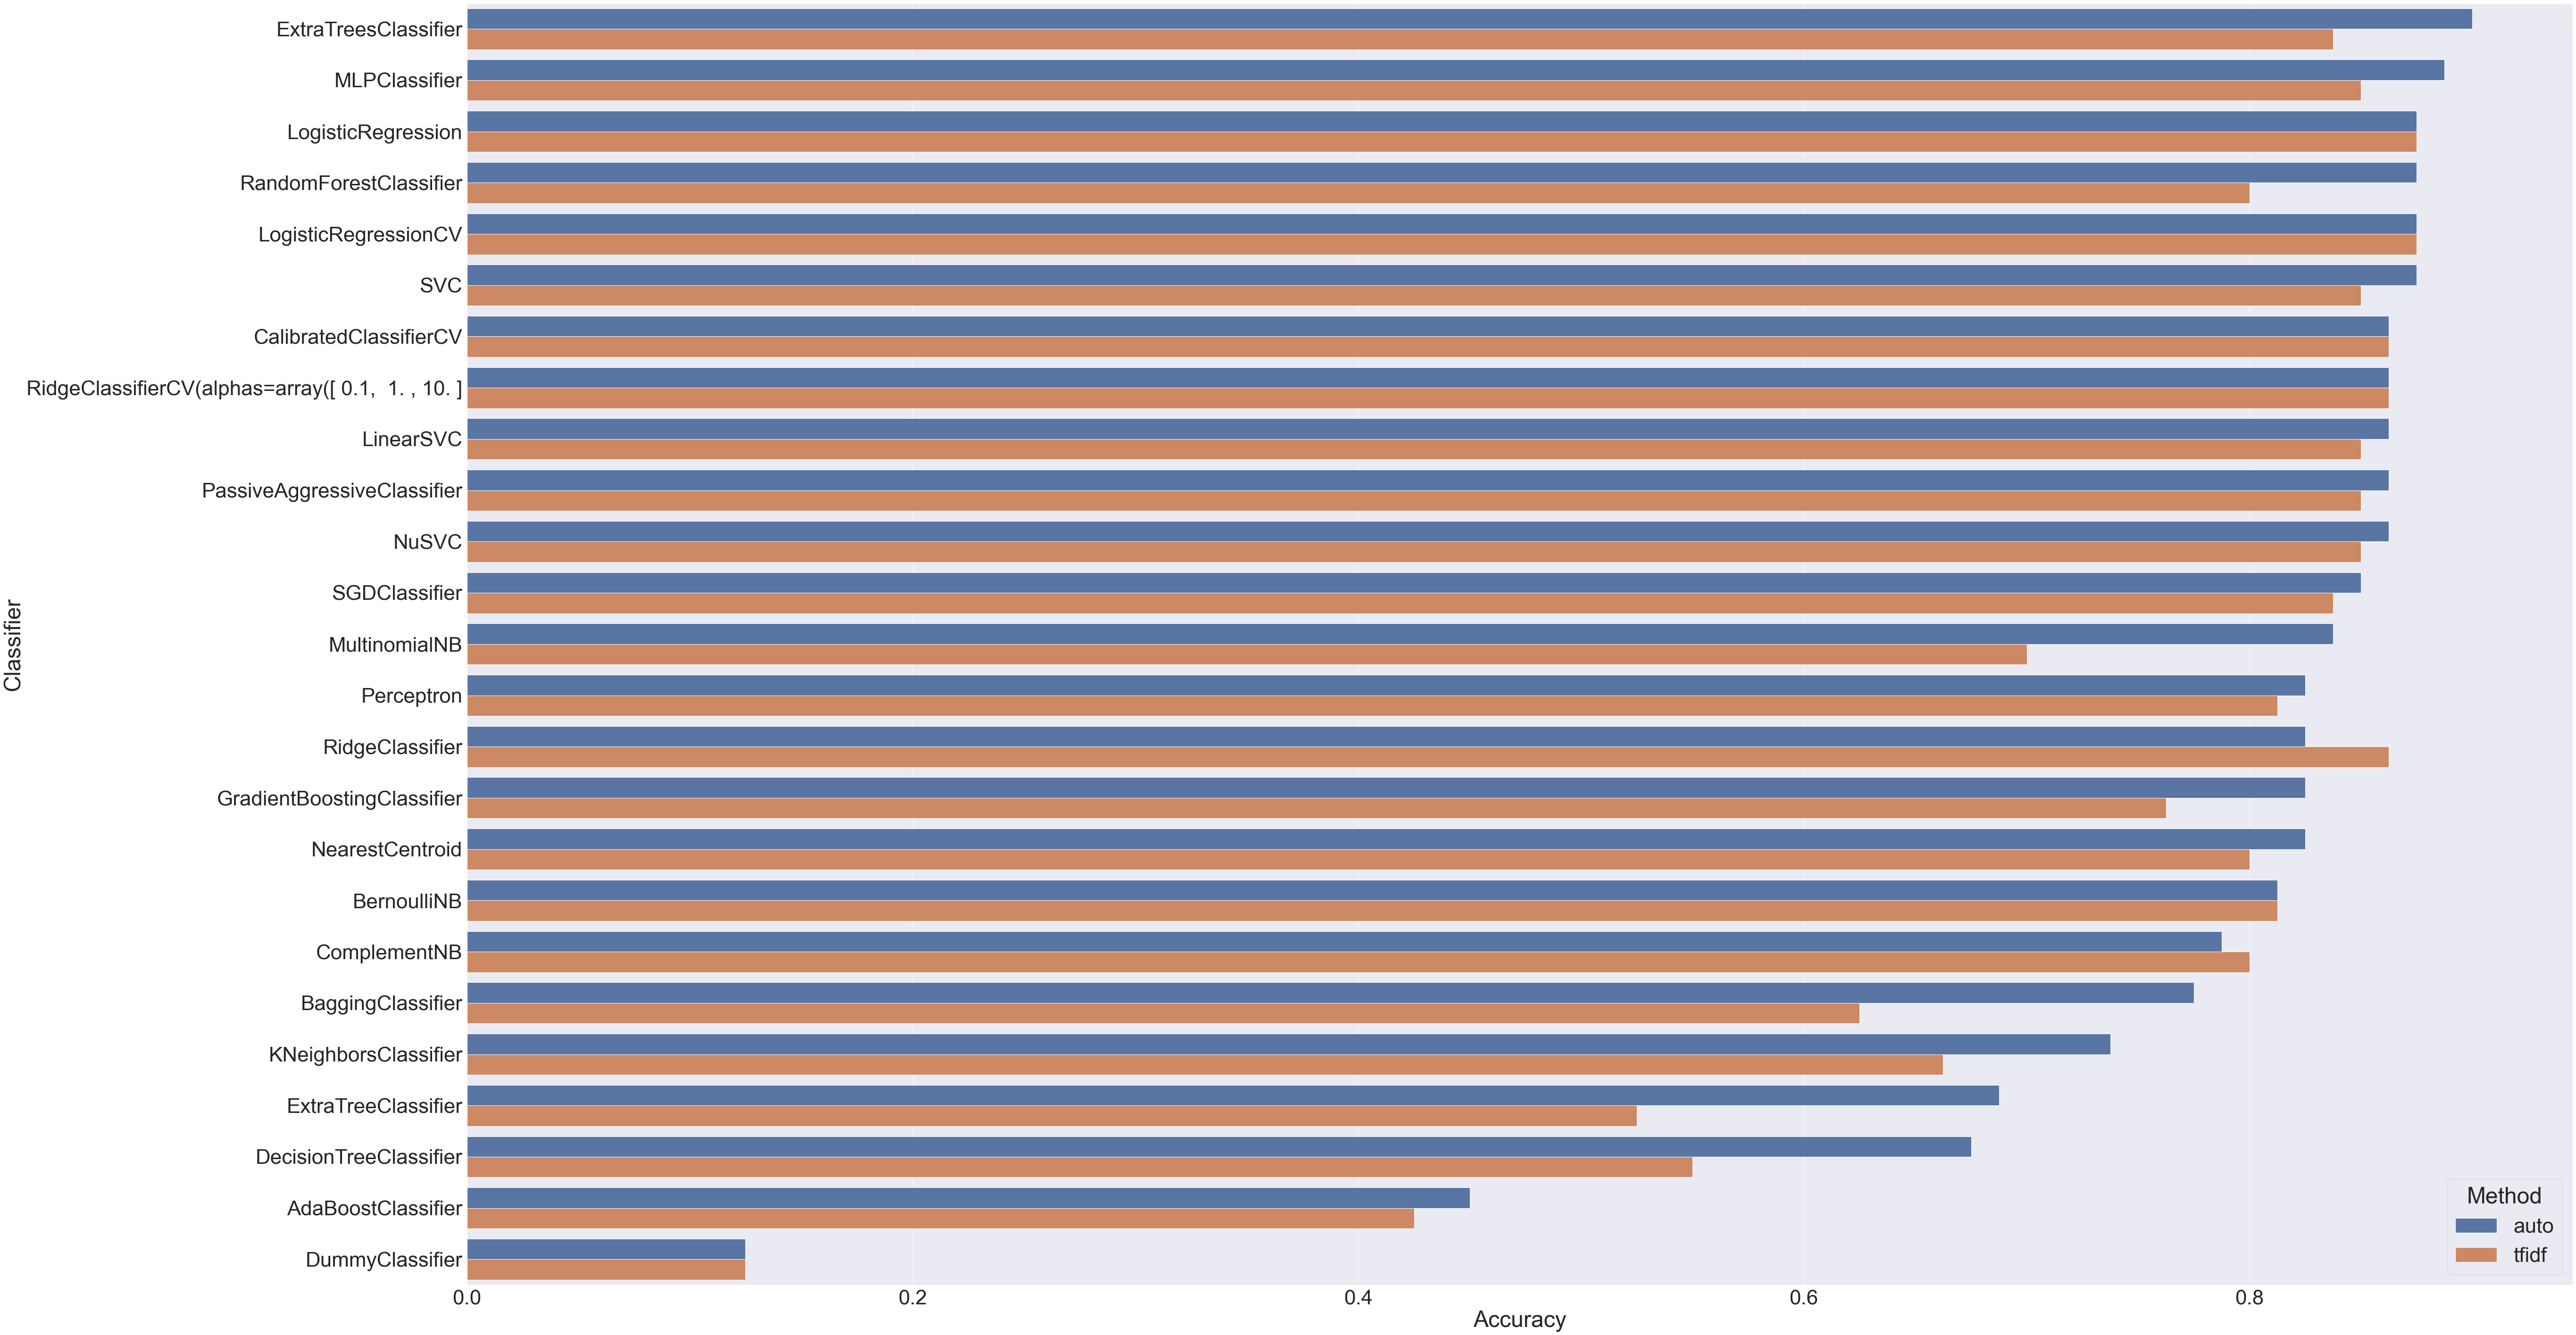

In [35]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
sns.barplot(
    data=all_classifier_combinations, 
    x="Accuracy", y="Classifier", hue="Method"
)

In [36]:
best_methods_auto = all_classifier_combinations

best_methods_auto = best_methods_auto.loc[best_methods_auto['Method'] == 'auto']

best_methods_auto = best_methods_auto.sort_values('Accuracy', ascending=False).drop_duplicates(['Classifier'])

best_methods_auto = best_methods_auto.loc[best_methods_auto['Accuracy'] > 0.865]

best_methods_auto

,Length of remove_list,Accuracy,Removed words,Classifier,Method
713,0.0,0.9000,[],ExtraTreesClassifier,auto
1137,17.0,0.8875,"[tablespoon, cup, teaspoon, oil, pepper, garli...",MLPClassifier,auto
1027,9.0,0.8750,"[tablespoon, cup, teaspoon, oil, pepper, garli...",LogisticRegression,auto
1699,0.0,0.8750,[],RandomForestClassifier,auto
1058,10.0,0.8750,"[tablespoon, cup, teaspoon, oil, pepper, garli...",LogisticRegressionCV,auto
1990,35.0,0.8750,"[tablespoon, cup, teaspoon, oil, sauc, pepper,...",SVC,auto


In [37]:
best_methods_tfidf = all_classifier_combinations

best_methods_tfidf = best_methods_tfidf.loc[best_methods_tfidf['Method'] == 'tfidf']

best_methods_tfidf = best_methods_tfidf.sort_values('Accuracy', ascending=False).drop_duplicates(['Classifier'])

best_methods_tfidf = best_methods_tfidf.loc[best_methods_tfidf['Accuracy'] > 0.865]

best_methods_tfidf

,Length of remove_list,Accuracy,Removed words,Classifier,Method
12,NaN,0.875,NaN,LogisticRegression,tfidf
13,NaN,0.875,NaN,LogisticRegressionCV,tfidf


# Erstellen der Pipelines für die Gridsearch

In [69]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MLPClassifier()),
])

pipeline2 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', ExtraTreesClassifier()),
])

pipeline3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier()),
])

pipeline4 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegressionCV()),
])

pipeline5 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression()),
])

pipeline6 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC()),
])


pipeline7 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', ExtraTreesClassifier()),
])

pipeline8 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegressionCV()),
])

pipeline9 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

# parameters for classifiers

#MLPClassifier
parameters1 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    #'clf__activation': ['tanh', 'relu'],
    #'clf__solver': ['sgd', 'adam'],
    # 'clf__alpha': [0.0001, 0.05],
    'clf__learning_rate': ['constant','adaptive'],
}

#ExtraTreesClassifier
parameters2 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__n_estimators': range(50,126,25),
    #'clf__max_features': range(50,401,50),
    #'clf__min_samples_leaf': range(20,50,5),
    #'clf__min_samples_split': range(15,36,5)
}

#RandomForestClassifier
parameters3 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'clf__n_estimators': [200, 500],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    #'clf__max_depth' : [4,5,6,7,8],
    'clf__criterion' :['gini', 'entropy']
}

#LogisticRegressionCV
parameters4 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
}

#LogisticRegression
parameters5 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #"clf__C":np.logspace(-3,3,7),
    #"clf__penalty":["l1","l2"]
}

#SVC
parameters6 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'clf__C': (1, 10, 100, 1000),
    'clf__gamma': (0.001, 0.0001,1, 2),
    'clf__kernel': ('linear', 'rbf'),
}

#ExtraTreesClassifier tfidf
parameters7 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #'clf__n_estimators': range(50,126,25),
    #'clf__max_features': range(50,401,50),
    #'clf__min_samples_leaf': range(20,50,5),
    #'clf__min_samples_split': range(15,36,5)
}

#LogisticRegressionCV tfidf
parameters8 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2')
}

#LogisticRegression tfidf
parameters9 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #"clf__C":np.logspace(-3,3,7),
    #"clf__penalty":["l1","l2"]
}

#List of every classifier without SVC

pipe = [pipeline1, pipeline2, pipeline3, pipeline4, pipeline5]

para = [parameters1, parameters2, parameters3, parameters4, parameters5]

#List of both SVC

pipe_svc = pipeline6

para_svc = parameters6

#List of every classifier combined with tfidf

pipe_tfidf = [pipeline7, pipeline8, pipeline9]

para_tfidf = [parameters7, parameters8, parameters9]


In [58]:
print(pipe)

[Pipeline(steps=[('vect', CountVectorizer()), ('clf', MLPClassifier())]), Pipeline(steps=[('vect', CountVectorizer()), ('clf', ExtraTreesClassifier())]), Pipeline(steps=[('vect', CountVectorizer()), ('clf', RandomForestClassifier())]), Pipeline(steps=[('vect', CountVectorizer()), ('clf', LogisticRegressionCV())]), Pipeline(steps=[('vect', CountVectorizer()), ('clf', LogisticRegression())])]


In [59]:
# List of remove Lists for auto classifiers

remove_list_list = best_methods_auto['Removed words'].tolist()


In [60]:
# Pop last entry for SVC comparsion

remove_list_svc = remove_list_list.pop(len(remove_list_list) - 1)

In [49]:
# Generate List with empty List and remove_list
# because: you never know what the gridsearch may bring
# svc linear has not been tested before

svc_remove_list = [[]]

svc_remove_list.append(remove_list_svc)

svc_remove_list

[[],
 ['tablespoon',
  'cup',
  'teaspoon',
  'oil',
  'sauc',
  'pepper',
  'garlic',
  'salt',
  'onion',
  'pound',
  'clove',
  'fresh',
  'ounc',
  'red',
  'sugar',
  'chicken',
  'oliv',
  'ground',
  'black',
  'egg',
  'water',
  'butter',
  'vinegar',
  'juic',
  'wine',
  'white',
  'chop',
  'veget',
  'boneless',
  'freshli',
  'powder',
  'broth',
  'larg',
  'pinch',
  'flake']]

# GridSearch of Support Vector Classifiers

In [43]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

SVC_GridSearchs = []

print(pipe_svc)
print(para_svc)


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for remove lists and the
    # classifier
    for remove_list in svc_remove_list:
        data = train
        data['cleanText_removed']=data['cleanText'].map(lambda s:remove_common_words(s, remove_list))
        
        print()
        print("Remove List")
        print(remove_list)
        print()
        grid_search = GridSearchCV(pipe_svc, para_svc, n_jobs=-1, verbose=1)

        

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipe_svc.steps])
        print("parameters:")
        pprint(para_svc)
        t0 = time()
        grid_search.fit(data.cleanText_removed, data.cuisine)
        SVC_GridSearchs.append(grid_search)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(para_svc.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        



Pipeline(steps=[('vect', CountVectorizer()), ('clf', SVC())])
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__C': (1, 10, 100, 1000), 'clf__gamma': (0.001, 0.0001, 1, 2), 'clf__kernel': ('linear', 'rbf')}

Remove List
[]

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': (1, 10, 100, 1000),
 'clf__gamma': (0.001, 0.0001, 1, 2),
 'clf__kernel': ('linear', 'rbf'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
done in 29.561s

Best score: 0.768
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'rbf'
	vect__max_df: 0.5
	vect__max_features: None
	vect__ngram_range: (1, 1)

Remove List
['tablespoon', 'cup', 'teaspoon', 'oil', 'sauc', 'pepper', 'garlic', 'salt', 'onion', 'pound', 'clove', 'fresh', 'ounc', 'red', 'sugar', 'chicken

In [70]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV 
auto_GridSearchs = []

print(pipe)
print("----------------")
print(para)
print("----------------")
print(remove_list_list)


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for remove lists and the
    # classifier
    for pipeline, parameters, remove_list in zip(pipe, para, remove_list_list):
        data = train
        data['cleanText_removed']=data['cleanText'].map(lambda s:remove_common_words(s, remove_list))
        
        print()
        print("Remove List")
        print(remove_list)
        print()

        grid_search = HalvingGridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

        

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters)
        t0 = time()
        grid_search.fit(data.cleanText_removed, data.cuisine)
        auto_GridSearchs.append(grid_search)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Pipeline(steps=[('vect', CountVectorizer()), ('clf', MLPClassifier())]), Pipeline(steps=[('vect', CountVectorizer()), ('clf', ExtraTreesClassifier())]), Pipeline(steps=[('vect', CountVectorizer()), ('clf', RandomForestClassifier())]), Pipeline(steps=[('vect', CountVectorizer()), ('clf', LogisticRegressionCV())]), Pipeline(steps=[('vect', CountVectorizer()), ('clf', LogisticRegression())])]
----------------
[{'vect__max_df': (0.5, 0.75, 1.0), 'clf__learning_rate': ['constant', 'adaptive']}, {'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__n_estimators': range(50, 126, 25)}, {'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_features': ['auto', 'sqrt', 'log2'], 'clf__criterion': ['gini', 'entropy']}, {'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000), 'vect__ngram_range': ((1, 1), (1, 2))}, {'vect__max_df': (0.5, 0.75, 1.0), 'vect__ma

In [72]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

tfidf_GridSearchs = []

print(pipe_tfidf)
print("----------------")
print(para_tfidf)


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for remove lists and the
    # classifier
    for pipeline, parameters in zip(pipe_tfidf, para_tfidf):
        data = train

        grid_search = HalvingGridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

        

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters)
        t0 = time()
        grid_search.fit(data.cleanText_removed, data.cuisine)
        tfidf_GridSearchs.append(grid_search)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best score: %0.3f" % grid_search.best_score_)
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', ExtraTreesClassifier())]), Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegressionCV())]), Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])]
----------------
[{'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000), 'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2')}, {'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000), 'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2')}, {'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000), 'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2')}]
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'tfidf__n